# Set up Feature_style_encoder

In [1]:
import shutil
import os

# Define a function to remove a directory and its contents recursively
def remove_folder(folder_path):
    shutil.rmtree(folder_path)

# Example usage:
if os.path.exists('/kaggle/working/FeatureStyleEncoder'):
    remove_folder('/kaggle/working/FeatureStyleEncoder')
    
%cd /kaggle/working/
!git clone https://github.com/InterDigitalInc/FeatureStyleEncoder.git

/kaggle/working
Cloning into 'FeatureStyleEncoder'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 129 (delta 10), reused 8 (delta 8), pack-reused 114
Receiving objects: 100% (129/129), 24.13 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!pip install face_alignment

In [3]:
%cd FeatureStyleEncoder

!pip install gdown
%mkdir pretrained_models
%cd pretrained_models

# download pretrained encoder
!gdown --fuzzy https://drive.google.com/file/d/1RnnBL77j_Can0dY1KOiXHvG224MxjvzC/view?usp=sharing

# download arcface pretrained model
!gdown --fuzzy https://drive.google.com/file/d/1coFTz-Kkgvoc_gRT8JFzqCgeC3lAFWQp/view?usp=sharing

# download face parsing model from https://github.com/zllrunning/face-parsing.PyTorch
!gdown --fuzzy https://drive.google.com/open?id=154JgKpzCPW82qINcVieuPH3fZ2e0P812
    
# download pSp pretrained model from https://github.com/eladrich/pixel2style2pixel.git
%cd ../pixel2style2pixel
!mkdir pretrained_models

%cd pretrained_models
!gdown --fuzzy https://drive.google.com/file/d/1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0/view?usp=sharing

/kaggle/working/FeatureStyleEncoder
/kaggle/working/FeatureStyleEncoder/pretrained_models
Downloading...
From (original): https://drive.google.com/uc?id=1RnnBL77j_Can0dY1KOiXHvG224MxjvzC
From (redirected): https://drive.google.com/uc?id=1RnnBL77j_Can0dY1KOiXHvG224MxjvzC&confirm=t&uuid=8b5833ab-3857-4141-aa7d-43389b7c3973
To: /kaggle/working/FeatureStyleEncoder/pretrained_models/143_enc.pth
100%|████████████████████████████████████████| 456M/456M [00:05<00:00, 83.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1coFTz-Kkgvoc_gRT8JFzqCgeC3lAFWQp
From (redirected): https://drive.google.com/uc?id=1coFTz-Kkgvoc_gRT8JFzqCgeC3lAFWQp&confirm=t&uuid=bad40cef-b747-4231-8d19-98ebcb1aebc0
To: /kaggle/working/FeatureStyleEncoder/pretrained_models/backbone.pth
100%|████████████████████████████████████████| 175M/175M [00:02<00:00, 61.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=154JgKpzCPW82qINcVieuPH3fZ2e0P812
To: /kaggle/working/FeatureStyleEncoder/pretrained_mode

In [4]:
%cd /kaggle/working/FeatureStyleEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import argparse
import glob
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import yaml

from PIL import Image
from tqdm import tqdm
from torchvision import transforms, utils
from utils.functions import *

from trainer import *

/kaggle/working/FeatureStyleEncoder


In [5]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(True)
Image.MAX_IMAGE_PIXELS = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu') 

parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, default='001', help='Path to the config file.')
parser.add_argument('--pretrained_model_path', type=str, default='./pretrained_models/143_enc.pth', help='pretrained stylegan2 model')
parser.add_argument('--stylegan_model_path', type=str, default='./pixel2style2pixel/pretrained_models/psp_ffhq_encode.pt', help='pretrained stylegan2 model')
parser.add_argument('--arcface_model_path', type=str, default='./pretrained_models/backbone.pth', help='pretrained arcface model')
parser.add_argument('--parsing_model_path', type=str, default='./pretrained_models/79999_iter.pth', help='pretrained parsing model')
parser.add_argument('--log_path', type=str, default='./logs/', help='log file path')
parser.add_argument('--resume', action='store_true', help='resume from checkpoint')
parser.add_argument('--checkpoint', type=str, default='', help='checkpoint file path')
parser.add_argument('--checkpoint_noiser', type=str, default='', help='checkpoint file path')
parser.add_argument('--multigpu', type=bool, default=False, help='use multiple gpus')
parser.add_argument('--input_path', type=str, default='./test/', help='evaluation data file path')
parser.add_argument('--save_path', type=str, default='./', help='output data save path')
fs_opts = parser.parse_args([])

In [6]:
img_to_tensor = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

config = yaml.load(open('./configs/' + fs_opts.config + '.yaml', 'r'), Loader=yaml.FullLoader)

# Initialize trainer
trainer = Trainer(config, fs_opts)
trainer.initialize(fs_opts.stylegan_model_path, fs_opts.arcface_model_path, fs_opts.parsing_model_path)  
trainer.to(device)

state_dict = torch.load(fs_opts.pretrained_model_path)#os.path.join(fs_opts.log_path, fs_opts.config + '/checkpoint.pth'))
trainer.enc.load_state_dict(torch.load(fs_opts.pretrained_model_path))
trainer.enc.eval()

print("Feature_style_encoder successfully loaded!")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s] 


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]  


Loading model from: /kaggle/working/FeatureStyleEncoder/lpips/weights/v0.1/alex.pth
Feature_style_encoder successfully loaded!


# Setup Hair Clip

In [7]:
!pip install torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install tensorflow-io
!pip install Ninja
!pip install dlib
!pip install cog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 842.9 kB/s eta 0:00:00a 0:00:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-roe2qan5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-roe2qan5
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=3676e33f520e30c1a457f60419f65c58cdeabbb36f8393755091ba62d6320a90
  Stored in directory: /tmp/pip-ephem-wheel-cache-ae3hwkx4/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310

In [8]:
import shutil
import os

# Define a function to remove a directory and its contents recursively
def remove_folder(folder_path):
    shutil.rmtree(folder_path)

# Example usage:
if os.path.exists('/kaggle/working/HairCLIP'):
    remove_folder('/kaggle/working/HairCLIP')
    
%cd /kaggle/working/
!git clone https://github.com/wty-ustc/HairCLIP.git

/kaggle/working
Cloning into 'HairCLIP'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 170 (delta 49), reused 153 (delta 40), pack-reused 0
Receiving objects: 100% (170/170), 40.34 MiB | 50.31 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [9]:
!gdown --id '1hqZT6ZMldhX3M_x378Sm4Z2HMYr-UwQ4' -O "/kaggle/working/HairCLIP/pretrained_models/hairclip.pt"
!gdown --id '1FS2V756j-4kWduGxfir55cMni5mZvBTv' -O "/kaggle/working/HairCLIP/pretrained_models/model_ir_se50.pth"
!gdown --id '1pts5tkfAcWrg4TpLDu6ILF5wHID32Nzm' -O "/kaggle/working/HairCLIP/pretrained_models/stylegan2-ffhq-config-f.pt"
!wget -P /kaggle/working/HairCLIP/pretrained_models http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK
!bunzip2 /kaggle/working/HairCLIP/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hqZT6ZMldhX3M_x378Sm4Z2HMYr-UwQ4
From (redirected): https://drive.google.com/uc?id=1hqZT6ZMldhX3M_x378Sm4Z2HMYr-UwQ4&confirm=t&uuid=b5d87b49-a97c-488d-a452-fc1b46c0bda6
To: /kaggle/working/HairCLIP/pretrained_models/hairclip.pt
100%|█████████████████████████████████████████| 565M/565M [00:05<00:00, 107MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1FS2V756j-4kWduGxfir55cMni5mZvBTv
From (redirected): https://drive.google.com/uc?id=1FS2V756j-4kWduGxfir55cMni5mZvBTv&conf

# LatentsDatasetInference.py

In [ ]:
%cd /kaggle/working/HairCLIP

In [10]:
from torch.utils.data import Dataset
import numpy as np
import clip
import torch
import random
from PIL import Image
import torchvision.transforms as transforms
sys.path.insert(0, "/kaggle/working/HairCLIP/mapper")
from training import train_utils
import os

In [11]:
class LatentsDatasetInference(Dataset):
    def __init__(self, latents, features, opts):
        self.latents = latents
        self.features = features
        self.opts = opts

        if self.opts.editing_type in ['hairstyle', 'both'] and self.opts.input_type.split('_')[0] == 'text':
            with open(self.opts.hairstyle_description, "r") as fd:
                self.hairstyle_description_list = fd.read().splitlines()
            self.hairstyle_list = [single_hairstyle_description[:-9] for single_hairstyle_description in self.hairstyle_description_list]
        if self.opts.editing_type in ['color', 'both'] and self.opts.input_type.split('_')[-1] == 'text':
            self.color_list = [single_color_description.strip()+' ' for single_color_description in self.opts.color_description.split(',')]
        if self.opts.editing_type in ['hairstyle', 'both'] and self.opts.input_type.split('_')[0] == 'image':
            self.out_domain_hairstyle_img_path_list = sorted(train_utils.make_dataset(self.opts.hairstyle_ref_img_test_path))
        if self.opts.editing_type in ['color', 'both'] and self.opts.input_type.split('_')[-1] == 'image':
            self.out_domain_color_img_path_list = sorted(train_utils.make_dataset(self.opts.color_ref_img_test_path))

        self.image_transform = transforms.Compose([transforms.Resize((1024, 1024)), transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [12]:
def manipulate_hairstyle(self, index):
    if self.opts.input_type.split('_')[0] == 'text':
        color_text_embedding_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
        color_tensor_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
        hairstyle_tensor_list = [torch.Tensor([0]) for i in range(len(self.hairstyle_list))]
        selected_hairstyle_description_list = [single_hairstyle_description+'hairstyle' for single_hairstyle_description in self.hairstyle_list]
        hairstyle_text_embedding_list = [torch.cat([clip.tokenize(selected_hairstyle_description)])[0] for selected_hairstyle_description in selected_hairstyle_description_list]
    elif self.opts.input_type.split('_')[0] == 'image':
        color_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        color_tensor_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        selected_hairstyle_description_list = ['hairstyle_out_domain_ref' for i in range(self.opts.num_of_ref_img)]
        hairstyle_tensor_list = [self.image_transform(Image.open(random.choice(self.out_domain_hairstyle_img_path_list))) for i in range(self.opts.num_of_ref_img)]
    return self.latents[index], self.features[index], hairstyle_text_embedding_list, color_text_embedding_list, selected_hairstyle_description_list, hairstyle_tensor_list, color_tensor_list

# Attach the function to the class
LatentsDatasetInference.manipulate_hairstyle = manipulate_hairstyle

In [13]:
def manipulater_color(self, index):
    if self.opts.input_type.split('_')[-1] == 'text':
        hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
        hairstyle_tensor_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
        color_tensor_list = [torch.Tensor([0]) for i in range(len(self.color_list))]
        selected_color_description_list = [single_color_description+'hair' for single_color_description in self.color_list]
        color_text_embedding_list = [torch.cat([clip.tokenize(selected_color_description)])[0] for selected_color_description in selected_color_description_list]
    elif self.opts.input_type.split('_')[-1] == 'image':
        hairstyle_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        hairstyle_tensor_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        color_text_embedding_list = [torch.Tensor([0]) for i in range(self.opts.num_of_ref_img)]
        selected_color_description_list = ['color_out_domain_ref' for i in range(self.opts.num_of_ref_img)]
        color_tensor_list = [self.image_transform(Image.open(random.choice(self.out_domain_color_img_path_list))) for i in range(self.opts.num_of_ref_img)]
    return self.latents[index], self.features[index], hairstyle_text_embedding_list, color_text_embedding_list, selected_color_description_list, hairstyle_tensor_list, color_tensor_list		

# Attach the function to the class
LatentsDatasetInference.manipulater_color = manipulater_color

In [14]:
def manipulater_hairstyle_and_color(self, index):
    returned_latent, returned_feature, hairstyle_text_embedding_list, _, selected_hairstyle_description_list, hairstyle_tensor_list, _ = self.manipulate_hairstyle(index)
    _, _, _, color_text_embedding_list, selected_color_description_list, _, color_tensor_list = self.manipulater_color(index)
    hairstyle_text_embedding_final_list = [hairstyle_text_embedding for hairstyle_text_embedding in hairstyle_text_embedding_list for i in color_text_embedding_list]
    color_text_embedding_final_list = [color_text_embedding for i in hairstyle_text_embedding_list for color_text_embedding in color_text_embedding_list]
    selected_description_list = [f'{selected_hairstyle_description}-{selected_color_description}' for selected_hairstyle_description in selected_hairstyle_description_list for selected_color_description in selected_color_description_list]
    hairstyle_tensor_final_list = [hairstyle_tensor for hairstyle_tensor in hairstyle_tensor_list for i in color_tensor_list]
    color_tensor_final_list = [color_tensor for i in hairstyle_tensor_list for color_tensor in color_tensor_list]
    return returned_latent, returned_feature, hairstyle_text_embedding_final_list, color_text_embedding_final_list, selected_description_list, hairstyle_tensor_final_list, color_tensor_final_list

# Attach the function to the class
LatentsDatasetInference.manipulater_hairstyle_and_color = manipulater_hairstyle_and_color

In [15]:
def __len__(self):
    return self.latents.shape[0]

# Attach the function to the class
LatentsDatasetInference.__len__ = __len__

In [16]:
def __getitem__(self, index):
    if self.opts.editing_type == 'hairstyle':
        return self.manipulate_hairstyle(index)
    elif self.opts.editing_type == 'color':
        return self.manipulater_color(index)
    elif self.opts.editing_type == 'both':
        return self.manipulater_hairstyle_and_color(index)
        
# Attach the function to the class
LatentsDatasetInference.__getitem__ = __getitem__

# Predict.py

In [17]:
%cd /kaggle/working/HairCLIP

import sys
import tempfile
from argparse import Namespace

import dlib
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from cog import BasePredictor, Path, Input
from criteria.parse_related_loss import average_lab_color_loss

/kaggle/working/HairCLIP


In [18]:
sys.path.insert(0, "/kaggle/working/HairCLIP/mapper")
# from mapper.datasets.latents_dataset_inference import LatentsDatasetInference
from mapper.hairclip_mapper import HairCLIPMapper
from mapper.options.test_options import TestOptions

In [19]:
%matplotlib inline
with open("mapper/hairstyle_list.txt") as infile:
    HAIRSTYLE_LIST = sorted([line.rstrip() for line in infile])


class Predictor(BasePredictor):
    def setup(self):
        pass
        
        
    def predict(
        self,
        image: Path = Input(
            description="Input image. Image will be aligned and resized. Output will be the "
            "concatenation of the inverted input and the image with edited hair."
        ),
        editing_type: str = Input(
            choices=["hairstyle", "color", "both"],
            default="hairstyle",
            description="Edit hairstyle or color or both.",
        ),
        input_type: str = Input(
            choices = ["text", "image", "text_image", "image_text"],
            description="(1)_(2):  (1) for hairstyle and (2) for color"
        ),
        hairstyle_description: str = Input(
            choices=HAIRSTYLE_LIST,
            default=None,
            description="Hairstyle text prompt. "
            "Valid if input_type is text or text_image.",
        ),
        hairstyle_ref_img_test_path: Path = Input(),
        
        color_description: str = Input(
            default=None,
            description="Color text prompt, eg: purple, red, orange. "
            "Valid if editing_type is color or both.",
        ),
        color_ref_img_test_path: Path = Input()
    ) -> Path:
        
        
        editing_type_ = str(editing_type).split(".")[-1]
        hairstyle_description_ = str(hairstyle_description).split(".")[-1]
        

        if editing_type_ == "both":
            assert (
                hairstyle_description_ is not None and color_description is not None
            ), ("Please provide description " "for both hairstyle and color.")
        elif editing_type_ == "hairstyle":
            assert (
                hairstyle_description_ is not None
            ), "Please provide description for hairstyle."
        else:
            assert (
                color_description is not None
            ), "Please provide description for color."
        
#     "------------------------------------------------------------------------------------"
        
        checkpoint_path = "pretrained_models/hairclip.pt"
        ckpt = torch.load(checkpoint_path, map_location="cpu")
        
        hc_opts = ckpt["opts"]
        hc_opts = Namespace(**hc_opts)
        
        hc_opts.num_of_ref_img = 5
        hc_opts.editing_type = editing_type_
        hc_opts.input_type = input_type
        hc_opts.color_description = color_description
        if hairstyle_description is not None:
            with open("hairstyle_description.txt", "w") as file:
                file.write(hairstyle_description_)

            hc_opts.hairstyle_description = "hairstyle_description.txt"
        hc_opts.color_ref_img_test_path = color_ref_img_test_path
        hc_opts.hairstyle_ref_img_test_path = hairstyle_ref_img_test_path
        
#     "------------------------------------------------------------------------------------"
    
        hc_opts.checkpoint_path = "pretrained_models/hairclip.pt"
        hc_opts.parsenet_weights = "pretrained_models/parsenet.pth"
        hc_opts.stylegan_weights = "pretrained_models/stylegan2-ffhq-config-f.pt"
        hc_opts.ir_se50_weights = "pretrained_models/model_ir_se50.pth"
        
        net = HairCLIPMapper(hc_opts)
        net.eval()
        net.cuda()

#     "------------------------------------------------------------------------------------"

        # first align, resize image and get latent code
        
        
        with torch.no_grad():
            input_image = img_to_tensor(Image.open(str(image))).unsqueeze(0).to(device)
            output = trainer.test(img=input_image, return_latent=True)
            feature = output.pop()
            latent = output.pop()

            print("Latent code calculated!")
            print(f"Latent code shape: {latent.shape}")
            print("Feature calculated")
            print(f"Feature shape: {feature.shape}")

            
        dataset = LatentsDatasetInference(latents=latent.cpu(), 
                                          features=feature.cpu(),
                                          opts=hc_opts)
        dataloader = DataLoader(dataset)

        average_color_loss = (
            average_lab_color_loss.AvgLabLoss(hc_opts).to(device).eval()
        )

        out_path = Path("/kaggle/working/output.png")

        for input_batch in tqdm(dataloader):

            with torch.no_grad():

                (
                    w,
                    Feature,
                    hairstyle_text_inputs_list,
                    color_text_inputs_list,
                    selected_description_tuple_list,
                    hairstyle_tensor_list,
                    color_tensor_list,
                ) = input_batch
                hairstyle_text_inputs = hairstyle_text_inputs_list[0]
                color_text_inputs = color_text_inputs_list[0]
                selected_description = selected_description_tuple_list[0][0]
                hairstyle_tensor = hairstyle_tensor_list[0]
                color_tensor = color_tensor_list[0]
                
                
                w = w.cuda().float()
                Feature = Feature.cuda().float()
                hairstyle_text_inputs = hairstyle_text_inputs.cuda()
                color_text_inputs = color_text_inputs.cuda()
                hairstyle_tensor = hairstyle_tensor.cuda()
                color_tensor = color_tensor.cuda()
                
                if hairstyle_tensor.shape[1] != 1:
                    hairstyle_tensor_hairmasked = (
                        hairstyle_tensor * average_color_loss.gen_hair_mask(hairstyle_tensor)
                    )
                else:
                    hairstyle_tensor_hairmasked = torch.Tensor([0]).unsqueeze(0).cuda()
                    
                if color_tensor.shape[1] != 1:
                    color_tensor_hairmasked = (
                        color_tensor * average_color_loss.gen_hair_mask(color_tensor)
                    )
                else:
                    color_tensor_hairmasked = torch.Tensor([0]).unsqueeze(0).cuda()
                    
                result_batch = run_on_batch(
                    w,
                    Feature,
                    hairstyle_text_inputs,
                    color_text_inputs,
                    hairstyle_tensor_hairmasked,
                    color_tensor_hairmasked,
                    net,
                )

                if (hairstyle_tensor.shape[1] != 1) and (color_tensor.shape[1] != 1):
                    img_tensor = torch.cat([hairstyle_tensor, color_tensor], dim=3)
                elif hairstyle_tensor.shape[1] != 1:
                    img_tensor = hairstyle_tensor
                elif color_tensor.shape[1] != 1:
                    img_tensor = color_tensor
                else:
                    img_tensor = None

                if img_tensor is not None:
                    if img_tensor.shape[3] == 1024:
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                img_tensor,
                                result_batch[0][0].unsqueeze(0),
                            ]
                        )
                    elif img_tensor.shape[3] == 2048:
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                result_batch[0][0].unsqueeze(0),
                                img_tensor[:, :, :, 0:1024],
                                img_tensor[:, :, :, 1024::],
                            ]
                        )
                        couple_output = torch.cat(
                            [
                                result_batch[2][0].unsqueeze(0),
                                result_batch[0][0].unsqueeze(0),
                                img_tensor[:, :, :, 0:1024],
                                img_tensor[:, :, :, 1024::],
                            ]
                        )
                else:
                    couple_output = torch.cat(
                        [
                            result_batch[2][0].unsqueeze(0),
                            result_batch[0][0].unsqueeze(0),
                        ]
                    )
                    
                torchvision.utils.save_image(
                    couple_output, str(out_path), normalize=True
                )

                
        return out_path

In [20]:
def run_on_batch(
    inputs,
    F,
    hairstyle_text_inputs,
    color_text_inputs,
    hairstyle_tensor_hairmasked,
    color_tensor_hairmasked,
    net,
):
    w = inputs
    features = [None]*5 + [F] + [None]*(17-5)

    with torch.no_grad():
        x, _ = trainer.StyleGAN(
            [w], input_is_latent=True, randomize_noise=False, features_in=features, feature_scale=min(1.0, 0.0001*1e5)
        )
        
        w_hat = w + 0.1 * net.mapper(
            w,
            hairstyle_text_inputs,
            color_text_inputs,
            hairstyle_tensor_hairmasked,
            color_tensor_hairmasked,
        )
        
        # calculate delta feature
        _, fea_0 = trainer.StyleGAN([w], input_is_latent=True, return_features=True)
        _, fea_1 = trainer.StyleGAN([w_hat], input_is_latent=True, return_features=True)

        features = [None]*5 + [F + fea_1[5] - fea_0[5]] + [None]*(17-5)
        x_hat, _ = trainer.StyleGAN([w_hat], input_is_latent=True, features_in=features, feature_scale=1.0)

        result_batch = (x_hat, w_hat, x)
    return result_batch

# Check image

## Input Image

In [21]:
import shutil
import os

# Define a function to remove a directory and its contents recursively
def remove_folder(folder_path):
    shutil.rmtree(folder_path)

# Example usage:
if os.path.exists('/kaggle/working/Image'):
    remove_folder('/kaggle/working/Image')

%cd /kaggle/working/
!git clone https://github.com/HongQuan2003/21522490_final_ACV.git /kaggle/working/Image

/kaggle/working
Cloning into '/kaggle/working/Image'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), 12.90 MiB | 14.84 MiB/s, done.


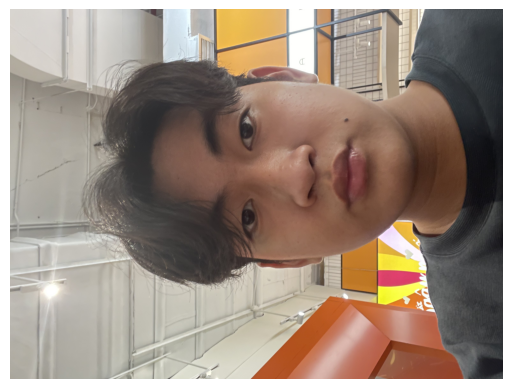

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io

input_image_path = "/kaggle/working/Image/Input_image/IMG_0800.jpeg"
input_image = io.read_image(input_image_path)

# Plot the image
plt.imshow(input_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Rotate if needed

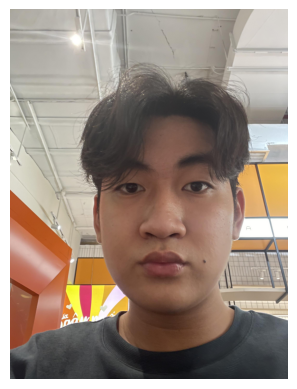

In [23]:
rotated_input_image_path = "/kaggle/working/rotated_input_image.jpeg"

# Rotate the image tensor by 90 degrees counter-clockwise
rotated_input_image = torch.rot90(input_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_input_image = TF.to_pil_image(rotated_input_image)

# Save the rotated image
rotated_input_image.save(rotated_input_image_path)

# Assuming 'image_tensor' is your image tensor
input_image = io.read_image(rotated_input_image_path)

# Plot the image
plt.imshow(input_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

input_image_path = rotated_input_image_path

### Do inversion

image: (2048, 1024)


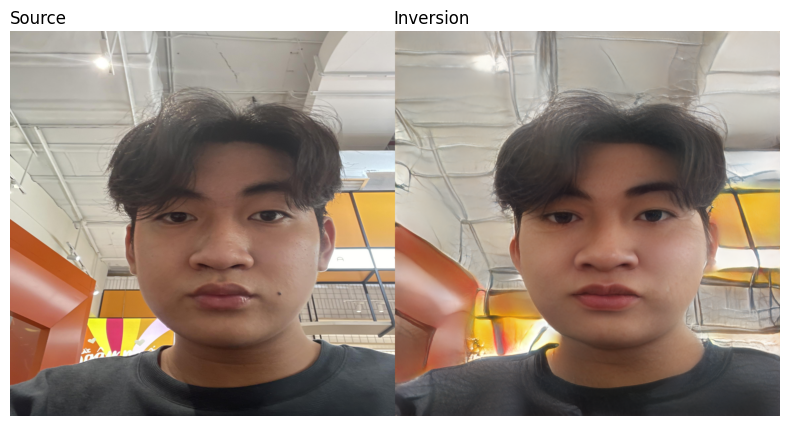

In [24]:
with torch.no_grad():        
    image_A = img_to_tensor(Image.open(input_image_path)).unsqueeze(0).to(device)
    output = trainer.test(img=image_A, return_latent=True)
    feature = output.pop()
    latent = output.pop()
    
    img = torch.cat(output, dim=3)
    img = np.clip(clip_img(img)[0].cpu().numpy()*255.,0,255).astype(np.uint8)
    img = Image.fromarray(img.transpose(1,2,0))
    print(f"image: {img.size}")
    plt.figure(figsize=(10,5))
    plt.text(0, -20, 'Source', size='large')
    plt.text(1020, -20, 'Inversion', size='large')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [25]:
print(f"latent: {latent.shape}")
print(f"feature: {feature.shape}")

latent: torch.Size([1, 18, 512])
feature: torch.Size([1, 512, 16, 16])


## Ref_image

### hairstyle

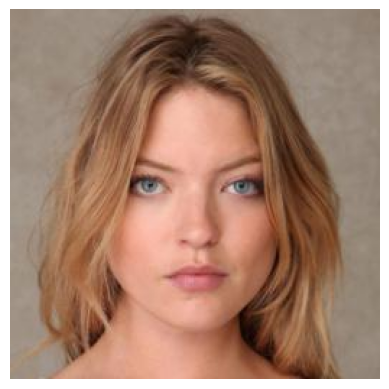

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io
import os

ref_image_path = "/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00002.jpg"

if os.path.exists('/kaggle/working/reference_image_hairstyle') == False:
    os.mkdir('/kaggle/working/reference_image_hairstyle')
    
ref_image = io.read_image(ref_image_path)
ref_image = TF.to_pil_image(ref_image)
ref_image.save("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")


ref_image = io.read_image("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")
# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Rotate (if needed)**

In [ ]:
# Rotate the image tensor by 90 degrees counter-clockwise
rotated_ref_image = torch.rot90(ref_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_ref_image = TF.to_pil_image(rotated_ref_image)

# Save the rotated image
rotated_ref_image.save("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")

# Assuming 'image_tensor' is your image tensor
ref_image = io.read_image("/kaggle/working/reference_image_hairstyle/ref_img.jpeg")

# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Color

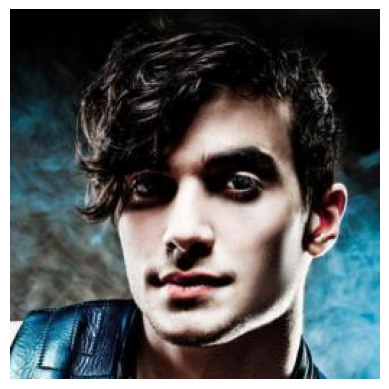

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io
import os

ref_image_path = "/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00003.jpg"

if os.path.exists('/kaggle/working/reference_image_color') == False:
    os.mkdir('/kaggle/working/reference_image_color')
    
ref_image = io.read_image(ref_image_path)
ref_image = TF.to_pil_image(ref_image)
ref_image.save("/kaggle/working/reference_image_color/ref_img.jpeg")


ref_image = io.read_image("/kaggle/working/reference_image_color/ref_img.jpeg")
# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

**Rotate (if needed)**

In [ ]:
# Rotate the image tensor by 90 degrees counter-clockwise
rotated_ref_image = torch.rot90(ref_image, k=-1, dims=(1, 2))

# Convert the rotated tensor back to a PIL Image
rotated_ref_image = TF.to_pil_image(rotated_ref_image)

# Save the rotated image
rotated_ref_image.save("/kaggle/working/reference_image_color/ref_img.jpeg")

# Assuming 'image_tensor' is your image tensor
ref_image = io.read_image("/kaggle/working/reference_image_color/ref_img.jpeg")

# Plot the image
plt.imshow(ref_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Edit hair with HairClip_FS

In [28]:
%cd /kaggle/working/HairCLIP

/kaggle/working/HairCLIP


In [29]:
Hair_clip_fs = Predictor()

In [30]:
%matplotlib inline

outpath = Hair_clip_fs.predict(
        image = input_image_path,
        editing_type = "both",
        input_type = "image_text",
        hairstyle_description = "undercut hairstyle",
        color_description = "blue",
        hairstyle_ref_img_test_path = "/kaggle/working/reference_image_hairstyle",
        color_ref_img_test_path = "/kaggle/working/reference_image_color",
)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 164MiB/s]


Loading from checkpoint: pretrained_models/hairclip.pt
Latent code calculated!
Latent code shape: torch.Size([1, 18, 512])
Feature calculated
Feature shape: torch.Size([1, 512, 16, 16])
Loading UNet for AvgLabLoss


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


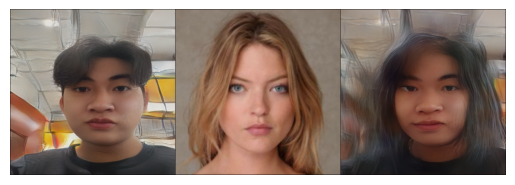

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.io as io

# Assuming 'image_tensor' is your image tensor
output_image = io.read_image(str(outpath))

# Plot the image
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')
plt.show()